<a class="anchor" id="top"></a>
# Analysis of Results Notebook
**Authors: Ainesh Pandey, Demian Gass, Gabriel Gilling**

In this notebook, we read in the model results and top-10 feature importances and analysed the results.

## Table of Contents

[Step 1: Import Required Packages](#step-1) <br>
[Step 2: Read Results and Recreate Master Dataframe](#step-2) <br>
[Step 3: Prep Results](#step-3) <br>
[Step 4: Analyze Results](#step-4) <br>

<a class="anchor" id="step-1"></a>

## Import Required Packages

In [1]:
# !pip install --upgrade seaborn

In [2]:
import pandas as pd
import pickle
import re
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

[Back to Top](#top)

<a class="anchor" id="step-2"></a>

## Read Results and Recreate Master Dataframe

### Model Results Dictionary

In [3]:
with open('/project_data/data_asset/model_results_dict.pkl', 'rb') as f:
    model_results_dict = pickle.load(f)

### Feature Results Dictionary

In [4]:
with open('/project_data/data_asset/feature_results_dict.pkl', 'rb') as f:
    feature_results_dict = pickle.load(f)

### Master Dataframe

In [5]:
# import deltas dataframe
df_deltas = pd.read_csv("/project_data/data_asset/delta_df.csv")

# import covariates dataframe
with open('/project_data/data_asset/df_demographics.pkl', 'rb') as f:
    df_covariates = pickle.load(f)

# combine both into base dataframe
df_base = df_deltas.merge(df_covariates, on='PublicID', how='inner')

# replace numbered values with string values for easier interpretability
race_recode = {'1': r'American Indian''\n'r'Alaska Native',
 '2': 'Asian',
 '3': r'Native Hawaiian''\n'r'Other Pacific Islander',
 '4': r'Black''\n'r'African American',
 '5': 'White',
 '6': 'More Than One Race',
 '7': r'Unknown''\n'r'Not Reported'}
df_base['eRace'] = df_base['eRace'].replace(race_recode)

# import targets dataframe
with open('/project_data/data_asset/targets_df.pkl', 'rb') as f:
    df_targets = pickle.load(f)

# one hot encode and merge with targets to create master dataframe
df_base_onehot = pd.get_dummies(df_base.drop(['PublicID'], axis = 1), prefix_sep = "__")
df_base_onehot = pd.concat([df_base['PublicID'], df_base_onehot, df_base['eRace']], axis = 1)
df_master = df_base_onehot.merge(df_targets, on = 'PublicID', how = 'inner')

[Back to Top](#top)

<a class="anchor" id="step-3"></a>

## Prep Results

### Helper Functions
This function helps visualize the means of the most important delta features across race.

In [6]:
def plot_relative_means(df_features, df_master):
    
    features = [x for x in df_features['Feature'] if '_delta_' in x]
    features.append('eRace')

    means = df_master[[col for col in features]].groupby('eRace').mean()
    
    i = 0
    j = 0
    
    if len(means.columns) == 8:
        fig, ax = plt.subplots(2,4, figsize = (16,8))
    
        for col in means:
        #     print(i,j)
            m = df_master[col].mean()
            means = means.sort_values(col)
            ax[i,j].plot(means[col], 'o', c='r')
            ax[i,j].axhline(m, label = 'Column Wide Mean')
            ax[i,j].set_xticklabels(labels = means.index, rotation = 90)
            ax[i,j].legend(title = col, loc = 'lower right')
            j += 1
            if j > 3:
                j = 0
                i += 1
        #     break
    elif len(means.columns) == 9:
        fig, ax = plt.subplots(3,3, figsize = (12,12))
    
        for col in means:
        #     print(i,j)
            m = df_master[col].mean()
            means = means.sort_values(col)
            ax[i,j].plot(means[col], 'o', c='r')
            ax[i,j].axhline(m, label = 'Column Wide Mean')
            ax[i,j].set_xticklabels(labels = means.index, rotation = 90)
            ax[i,j].legend(title = col, loc = 'lower right')
            j += 1
            if j > 2:
                j = 0
                i += 1
    fig.tight_layout()

### Select Best Model and Feature Importances

We first drop analyses that do not have enough support (fewer than 50 positive cases of the target). For the ones that satisfy our requirements, we select the better performing model's feature importances.

In [7]:
targets_to_drop = []

for target in model_results_dict:
    
    # extract the model and features results
    model_results = model_results_dict[target]
    feature_results = feature_results_dict[target]
    
    # get the F-1 scores for both modeling approaches
    f1_scores = {}
    f1_scores['LogR'] = model_results['LogR']['1.0']['f1-score']
    f1_scores['RanF'] = model_results['RanF']['1.0']['f1-score']
    f1_scores['LGBM'] = model_results['LGBM']['1.0']['f1-score']
    
    # get the analysis with the best F-1 score
    best_model = max(f1_scores, key=f1_scores.get)
    
    # get the positive class support
    support = model_results[best_model]['1.0']['support']
    
    # for targets that satisfy our support requirement, drop the unnecessary feature importance column
    if support >= 50:
        if best_model == 'LogR':
            feature_results.drop(['RanF_FeatureImportance', 'LGBM_FeatureImportance'],
                                 axis=1, inplace=True, errors='ignore')
            print("Selecting LogR for", target)
        elif best_model == 'RanF':
            feature_results.drop(['LogR_FeatureImportance', 'LGBM_FeatureImportance'],
                                 axis=1, inplace=True, errors='ignore')
            print("Selecting RanF for", target)
        else:
            feature_results.drop(['LogR_FeatureImportance', 'RanF_FeatureImportance'],
                                 axis=1, inplace=True, errors='ignore')
            print("Selecting LGBM for", target)
        feature_results_dict[target] = feature_results
    # for targets that don't satisfy our support requirement, drop the target from further analysis
    else:
        targets_to_drop.append(target)
        print("Dropping", target)
        
for target in targets_to_drop:
    del model_results_dict[target]
    del feature_results_dict[target]
    
print()
print('Considering', len(model_results_dict), 'analyses...')

Dropping CMAD01a
Dropping CMAD01b
Dropping CMAD01c
Dropping CMAD01d
Dropping CMAD01e
Dropping CMAD01h
Selecting LGBM for CMAE04a1c
Selecting LGBM for CMAE04a2c
Dropping CMAE04a3c
Dropping CMAE04a4c
Selecting LGBM for ChronHTN
Dropping Miscarriage
Selecting RanF for PEgHTN
Dropping Stillbirth
Dropping Termination

Considering 4 analyses...


For the models that remain, we extract the top 10 most impactful features, including both covariates and the delta features.

In [8]:
top10_features_dict = {}

def topN_features(target, n):
    feature_results = feature_results_dict[target]
    return feature_results.sort_values(feature_results.columns[-1], ascending=False).iloc[:n]
    
for target in feature_results_dict:
    top10_features_dict[target] = topN_features(target, 10)

[Back to Top](#top)

<a class="anchor" id="step-4"></a>

## Analyze Results

***
### ChronHTN: Chronic Hypertension
***

Shape of Target Dataframe: (456, 3406)
Support for Chronic Hypertension Cases: 68
F1 Score from LGBM Model for Target=1: 0.76


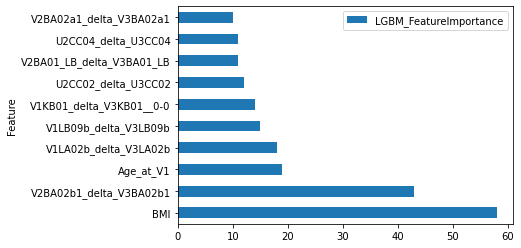

In [9]:
with open('/project_data/data_asset/df_ChronHTN.pkl', 'rb') as f:
    df_target = pickle.load(f)

df_features = top10_features_dict['ChronHTN']
support = model_results_dict['ChronHTN']['LGBM']['1.0']['support']
f1 = model_results_dict['ChronHTN']['LGBM']['1.0']['f1-score']

print('Shape of Target Dataframe:', str(df_target.shape))
print('Support for Chronic Hypertension Cases:', support)
print('F1 Score from LGBM Model for Target=1:', round(f1, 2))
df_features.plot.barh(x = 'Feature', y = df_features.columns[-1]);

For **Chronic Hypertension**, the most important delta features are the following:
- `V2BA02b1_delta_V3BA02b1`: The change in diastolic resting blood pressure between Visit 2 and Visit 3.
- `V1LA02b_delta_V3LA02b`: The change in hours of sleep per night on weekends between Visit 1 and Visit 3.
- `V1LB09b_delta_V3LB09b`: The change in how often they wake up during the night between Visit 1 and Visit 3.
- `V1KB01_delta_V3KB01__0-0`: The change in how well they slept the night before Visit 1 and Visit 3 remaining *missing*.
- `U2CC02_delta_U3CC02`: The change in heart rate (in bpm) in the left uterine artery between Visit 2 and Visit 3.
- `V2BA01_LB_delta_V3BA01_LB`: The change in weight (in lbs) between Visit 2 and Visit 3. `CHECK`
- `U2CC04_delta_U3CC04`: The change in peak systolic velocity (PSV in cm/sec) in the left uterine artery between Visit 2 and Visit 3.
- `V2BA02a1_delta_V3BA02a1`: The change in systolic resting blood pressure between Visit 2 and Visit 3.


Since the support for this target feature is acceptable (68 cases of chronic hypertension in the test set of our analysis), we can conclude the following:
- The change in diastolic and systolic resting blood pressure between Visit 2 and Visit 3 is highly indicative of the development of chronic hypertension during pregnancy. However, this may seem somewhat obvious, since hypertension refers to high blood pressure.
- The change in certain sleep habits throughout the pregnancy are highly indicative of the development of chronic hypertension during pregnancy.
- The change in heart rate or PSV in the left uterine artery, along with a change in weight, between Visit 2 and Visit 3 are highly indicative of the development of chronic hypertension during pregnancy.

Since chronic hypertension during pregnancy is a contributing risk factor to many instances of other maternal morbidities, these findings may offer worthwhile research pursuits.

Now, we look at the distribution of these impactful features by race, to determine if any particular minority class of women displays distinctly different distributional behavior when compared to white women.

***
### CMAE04a1c: Postpartum Depression
***

Shape of Target Dataframe: (676, 3406)
Support for Postpartum Depression Cases: 101
F1 Score from LGBM Model for Target=1: 0.73


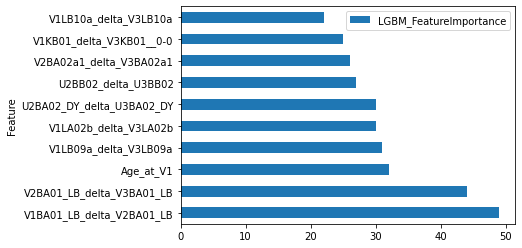

In [10]:
with open('/project_data/data_asset/df_CMAE04a1c.pkl', 'rb') as f:
    df_target = pickle.load(f)

df_features = top10_features_dict['CMAE04a1c']
support = model_results_dict['CMAE04a1c']['LGBM']['1.0']['support']
f1 = model_results_dict['CMAE04a1c']['LGBM']['1.0']['f1-score']

print('Shape of Target Dataframe:', str(df_target.shape))
print('Support for Postpartum Depression Cases:', support)
print('F1 Score from LGBM Model for Target=1:', round(f1, 2))
df_features.plot.barh(x = 'Feature', y = df_features.columns[-1]);

For **Postpartum Depression**, the most important delta features are the following:
- `V1BA01_LB_delta_V2BA01_LB`: The change in weight (in lbs) between Visit 1 and Visit 2.
- `V2BA01_LB_delta_V3BA01_LB`: The change in weight (in lbs) between Visit 2 and Visit 3.
- `V1LB09a_delta_V3LB09a`: The change in how often they wake up during the night between Visit 1 and Visit 3.
- `V1LA02b_delta_V3LA02b`: The change in hours of sleep per night on weekends between Visit 1 and Visit 3.
- `U2BA02_DY_delta_U3BA02_DY`: The change in gestational age by project estimated date of delivery between Visit 2 and Visit 3.
- `U2BB02_delta_U3BB02`: The change in cervical length (in mm) between Visit 2 and Visit 3.
- `V2BA02a1_delta_V3BA02a1`: The change in systolic resting blood pressure between Visit 2 and Visit 3.
- `V1KB01_delta_V3KB01__0-0`: The change in how well they slept the night before Visit 1 and Visit 3 remaining *missing*.
- `V1LB10a_delta_V3LB10a`: The change in how often they had to get out of bed between Visit 1 and Visit 3.


Since the support for this target feature is acceptable (101 cases of postpartum depression in the test set of our analysis), we can conclude the following:
- The change in weight of the mother throughout the pregnancy is highly indicative of the development of postpartum depression.
- The change in certain sleep habits of the mother throughout the pregnancy are highly indicative of the development of postpartum depression.
- The change in the gestational age of the fetus and cervical length between Visit 2 and Visit 3 is highly indicative of the development of postpartum depression.
- The change in the systolic blood pressure in the mother between Visit 2 and Visit 3 is highly indicative of the development of postpartum depression.

Since postpartum depression is such a _______ form of maternal morbidity, these findings may offer worthwhile research pursuits.

Now, we look at the distribution of these impactful features by race, to determine if any particular minority class of women displays distinctly different distributional behavior when compared to white women.

***
### CMAE04a2c: Postpartum Anxiety
***

Shape of Target Dataframe: (482, 3406)
Support for Postpartum Anxiety Cases: 72
F1 Score from LGBM Model for Target=1: 0.73


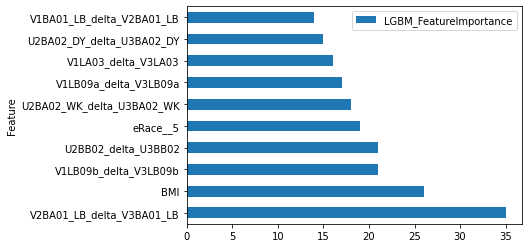

In [11]:
with open('/project_data/data_asset/df_CMAE04a2c.pkl', 'rb') as f:
    df_target = pickle.load(f)

df_features = top10_features_dict['CMAE04a2c']
support = model_results_dict['CMAE04a2c']['LGBM']['1.0']['support']
f1 = model_results_dict['CMAE04a2c']['LGBM']['1.0']['f1-score']

print('Shape of Target Dataframe:', str(df_target.shape))
print('Support for Postpartum Anxiety Cases:', support)
print('F1 Score from LGBM Model for Target=1:', round(f1, 2))
df_features.plot.barh(x = 'Feature', y = df_features.columns[-1]);

For **Postpartum Anxiety**, the most important delta features are the following:
- `V2BA01_LB_delta_V3BA01_LB`: The change in weight (in lbs) between Visit 2 and Visit 3.
- `V1LB09b_delta_V3LB09b`: The change in how often they wake up during the night between Visit 1 and Visit 3.
- `U2BB02_delta_U3BB02`: The change in cervical length (in mm) between Visit 2 and Visit 3.
- `U2BA02_WK_delta_U3BA02_WK`: The change in gestational age by project estimated date of delivery between Visit 2 and Visit 3.
- `V1LB09a_delta_V3LB09a`: The change in how often they wake up during the night between Visit 1 and Visit 3.
- `V1LA03_delta_V3LA03`: The change in how long it takes to fall asleep at bedtime between Visit 1 and Visit 3.
- `U2BA02_DY_delta_U3BA02_DY`: The change in gestational age by project estimated date of delivery between Visit 2 and Visit 3.
- `V1BA01_LB_delta_V2BA01_LB`: The change in weight (in lbs) between Visit 1 and Visit 2.

Since the support for this target feature is acceptable (72 cases of postpartum anxiety in the test set of our analysis), we can conclude the following:
- The change in weight of the mother throughout the pregnancy is highly indicative of the development of postpartum anxiety.
- The change in certain sleep habits of the mother throughout the pregnancy are highly indicative of the development of postpartum anxiety.
- The change in the gestational age of the fetus and cervical length between Visit 2 and Visit 3 is highly indicative of the development of postpartum depression.

Since postpartum anxiety is such a _______ form of maternal morbidity, these findings may offer worthwhile research pursuits. Furthermore, the significant overlap between the indicative features for postpartum depression and postpartum anxienty may be interesting to note.

Now, we look at the distribution of these impactful features by race, to determine if any particular minority class of women displays distinctly different distributional behavior when compared to white women.

***
### PEgHTN: Preeclampsia
***

Shape of Target Dataframe: (4080, 3406)
Support for Preeclampsia Cases: 612
F1 Score from LGBM Model for Target=1: 0.63


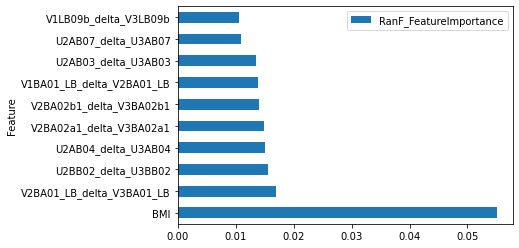

In [12]:
with open('/project_data/data_asset/df_PEgHTN.pkl', 'rb') as f:
    df_target = pickle.load(f)

df_features = top10_features_dict['PEgHTN']
support = model_results_dict['PEgHTN']['RanF']['1.0']['support']
f1 = model_results_dict['PEgHTN']['RanF']['1.0']['f1-score']

print('Shape of Target Dataframe:', str(df_target.shape))
print('Support for Preeclampsia Cases:', support)
print('F1 Score from LGBM Model for Target=1:', round(f1, 2))
df_features.plot.barh(x = 'Feature', y = df_features.columns[-1]);

For **Preeclampsia**, the most important delta features are the following:
- `V2BA01_LB_delta_V3BA01_LB`: The change in weight (in lbs) between Visit 2 and Visit 3.
- `U2BB02_delta_U3BB02`: The change in cervical length (in mm) between Visit 2 and Visit 3.
- `U2AB04_delta_U3AB04`: The change in abdominal circumference (in cm) between Visit 2 and Visit 3.
- `V2BA02a1_delta_V3BA02a1`: The change in systolic resting blood pressure between Visit 2 and Visit 3.
- `V2BA02b1_delta_V3BA02b1`: The change in diastolic resting blood pressure between Visit 2 and Visit 3.
- `V1BA01_LB_delta_V2BA01_LB`: The change in weight (in lbs) between Visit 1 and Visit 2.
- `U2AB03_delta_U3AB03`: The change in head circumference (in cm) between Visit 2 and Visit 3.
- `U2AB07_delta_U3AB07`: The change in estimated fetal weight percentile between Visit 2 and Visit 3.
- `V1LB09b_delta_V3LB09b`: The change in how often they wake up during the night between Visit 1 and Visit 3.


The support for this target feature is very good (612 cases of preeclampsia in the test set of our analysis), we can conclude the following:
- xyz

***
### Racial Distributions of Features
***

Now, we look at the distribution of these impactful features by race, to determine if any particular minority class of women displays distinctly different distributional behavior when compared to white women.

Relative means of highest impact delta features for Target=CMAE04a1c


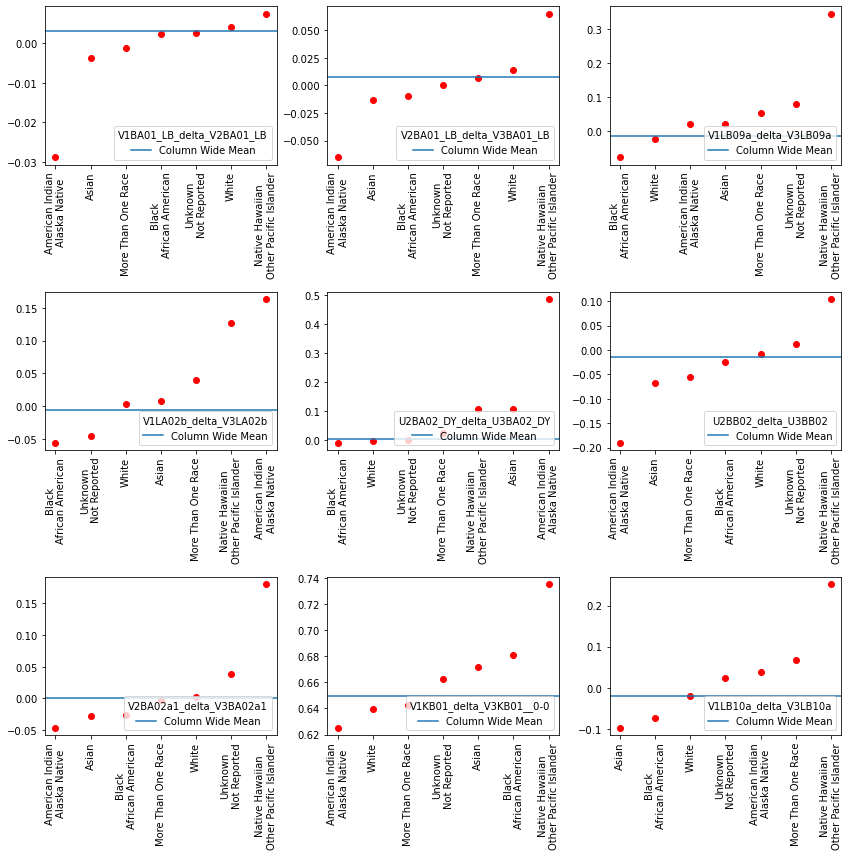



Relative means of highest impact delta features for Target=CMAE04a2c


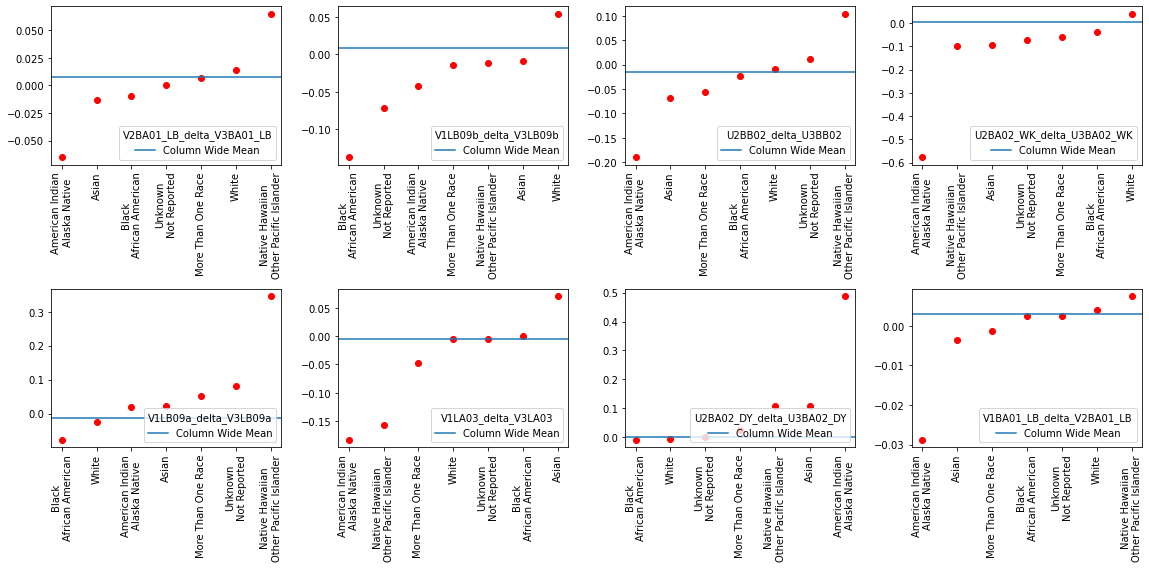



Relative means of highest impact delta features for Target=ChronHTN


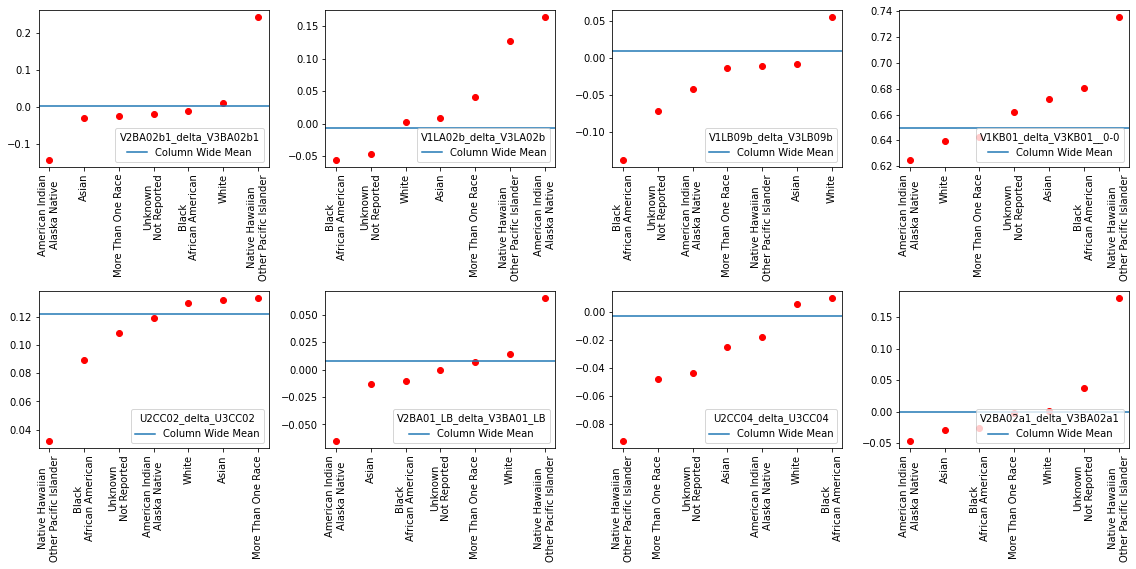



Relative means of highest impact delta features for Target=PEgHTN


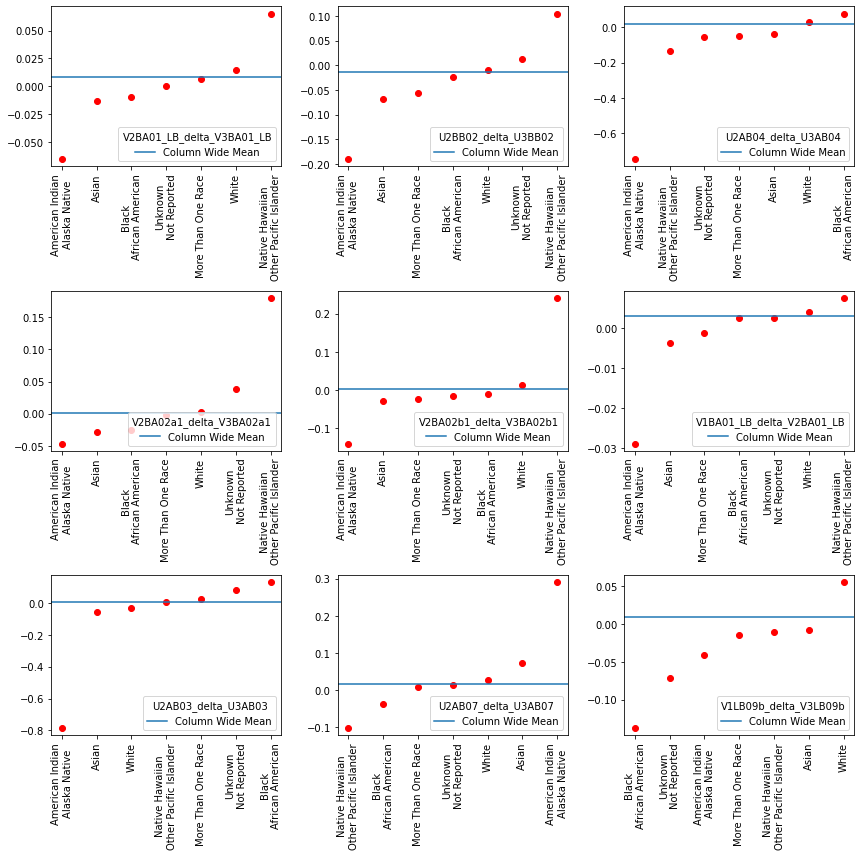

In [13]:
for target in feature_results_dict:
    print('Relative means of highest impact delta features for Target=' + target)
    plot_relative_means(top10_features_dict[target], df_master)
    plt.show()
    print()
    print()

Based on the distribution of the means, we can arrive at the following conclusions about:
- which morbidities the identified features have an impact on,
- how the majority class (white) is affected by each feature, and
- which minority classes, if any, are disproportionately affected

| Feature | Genre | Delta Start | Delta End | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Impacted Morbidities | Behavior of Majority Class (White) | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Disproportionately Affected Races, if Any |
| --- | --- | --- | --- | --- | --- | --- |
| V2BA02b1_delta_V3BA02b1 | diastolic blood pressure | Visit 2 | Visit 3 | Chronic Hypertension <br> Preeclampsia | Mean | Native Hawaiian / Other Pacific Islander <br> American Indian / Alaskan Native |
| V2BA02a1_delta_V3BA02a1 | systolic blood pressure | Visit 2 | Visit 3 | Chronic Hypertension  <br> Postpartum Depression <br> Preeclampsia | Mean | Native Hawaiian / Other Pacific Islander |
| V1LA02b_delta_V3LA02b | sleep behavior | Visit 1 | Visit 3 | Chronic Hypertension <br> Postpartum Depression | Mean | Native Hawaiian / Other Pacific Islander <br> American Indian / Alaskan Native |
| V1LA03_delta_V3LA03 | sleep behavior | Visit 1 | Visit 3 | Postpartum Anxiety | Mean | Asian, American Indian / Alaskan Native <br> Native Hawaiian / Other Pacific Islander |
| V1LB09a_delta_V3LB09a | sleep behavior | Visit 1 | Visit 3 | Postpartum Depression <br> Postpartum Anxiety | Mean | Native Hawaiian / Other Pacific Islander |
| V1LB09b_delta_V3LB09b | sleep behavior | Visit 1 | Visit 3 | Chronic Hypertension <br> Postpartum Anxiety <br> Preeclampsia | Highest | Black / African American |
| V1LB10a_delta_V3LB10a | sleep behavior | Visit 1 | Visit 3 | Postpartum Depression | Mean | Native Hawaiian / Other Pacific Islander |
| V1KB01_delta_V3KB01__0-0 | sleep behavior | Visit 1 | Visit 3 | Chronic Hypertension <br> Postpartum Depression | Lower | Native Hawaiian / Other Pacific Islander |
| U2AB03_delta_U3AB03 | head circumference | Visit 2 | Visit 3 | Preeclampsia | Mean | American Indian / Alaskan Native |
| U2AB04_delta_U3AB04 | abdominal circumference | Visit 2 | Visit 3 | Preeclampsia | Mean | American Indian / Alaskan Native |
| U2AB07_delta_U3AB07 | fetal weight | Visit 2 | Visit 3 | Preeclampsia | Mean | Native Hawaiian / Other Pacific Islander <br> American Indian / Alaskan Native |
| U2CC02_delta_U3CC02 | heart rate | Visit 2 | Visit 3 | Chronic Hypertension | Higher | Native Hawaiian / Other Pacific Islander |
| U2BB02_delta_U3BB02 | cervical length | Visit 2 | Visit 3 | Postpartum Depression <br> Postpartum Anxiety <br> Preeclampsia | Mean | Native Hawaiian / Other Pacific Islander <br> American Indian / Alaskan Native |
| V1BA01_LB_delta_V2BA01_LB | weight | Visit 1 | Visit 2 | Postpartum Depression <br> Postpartum Anxiety <br> Preeclampsia | Mean | American Indian / Alaskan Native |
| V2BA01_LB_delta_V3BA01_LB | weight | Visit 2 | Visit 3 | Chronic Hypertension <br> Postpartum Depression <br> Postpartum Anxiety <br> Preeclampsia | Mean | Native Hawaiian / Other Pacific Islander <br> American Indian / Alaskan Native |
| U2CC04_delta_U3CC04 | PSV | Visit 2 | Visit 3 | Chronic Hypertension | Higher | Native Hawaiian / Other Pacific Islander |
| U2BA02_DY_delta_U3BA02_DY | gestational age | Visit 2 | Visit 3 | Postpartum Depression <br> Postpartum Anxiety | Mean | American Indian / Alaskan Native |
| U2BA02_WK_delta_U3BA02_WK | gestational age | Visit 2 | Visit 3 | Postpartum Anxiety | Highest | American Indian / Alaskan Native |

[Back to Top](#top)